In [1]:
import pysam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vcf = pysam.VariantFile('/project/jnovembre/jhmarcus/ancient-sardinia/output/vcf/ancient_sardinia_full26_trm.vcf.gz')

In [3]:
samples = list(vcf.header.samples)
#cnt = 0
#for rec in vcf.fetch():
#    cnt += 1
#nsnps = cnt
nsnps = 1151240

In [4]:
shape = (len(samples), nsnps)
l_00 = np.zeros(shape)
l_01 = np.zeros(shape)
l_11 = np.zeros(shape)
print(shape)

(26, 1151240)


In [5]:
j = 0
mask = np.ones(shape)
for rec in vcf.fetch():
    for s in range(len(samples)):
        if (sum(rec.samples[samples[s]]["AD"]) < 2):
            mask[s, j] = 0
            continue        
        l_00[s, j] = rec.samples[samples[s]]["GL"][0]
        l_01[s, j] = rec.samples[samples[s]]["GL"][1]
        l_11[s, j] = rec.samples[samples[s]]["GL"][2]
    j += 1

In [6]:
p_00 = np.power(10, l_00)
p_01 = np.power(10, l_01)
p_11 = np.power(10, l_11)

In [7]:
P = np.zeros(shape = (len(samples), nsnps, 3))
P[:,:,0] = p_00 / (p_00 + p_01 + p_11)
P[:,:,1] = p_01 / (p_00 + p_01 + p_11)
P[:,:,2] = p_11 / (p_00 + p_01 + p_11)

# check number of SNPs
(P[:,:,0] > 0.8).sum() + (P[:,:,1] > 0.8).sum() + (P[:,:,2] > 0.8).sum()

3723730

In [8]:
%load_ext Cython

In [9]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double compute_distance(int i, int j, double[:, :, :] P, double [:,:] mask):
    cdef double d = 0.0
    cdef int nsnps = P.shape[1]
    cdef int l  = 0
    cdef int k1 = 0
    cdef int k2 = 0
    for l in range(nsnps):
        
        if (mask[i,l]):
            continue
            
        for k1 in [0,1,2]:
            for k2 in [0,1,2]:
                d += (k1-k2)*(k1-k2) * P[i, l, k1] * P[j, l, k2]
                
    return(d)

In [10]:
D = np.zeros(shape = (len(samples), len(samples)))
for i in range(len(samples)):
    for j in range((i+1), len(samples)):
            D[i,j] = compute_distance(i,j, P, mask)
            D[j,i] = D[i,j]
D = D / nsnps

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.]),
 array([0.        , 0.1342488 , 0.2684976 , 0.40274639, 0.53699519,
        0.67124399, 0.80549279, 0.93974159, 1.07399039, 1.20823918,
        1.34248798]),
 <a list of 10 Patch objects>)

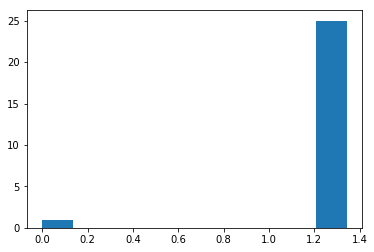

In [11]:
plt.hist(D[1,])

In [12]:
np.savetxt('anc_sards.diffs', D, delimiter=',', fmt='%1.8f')

In [13]:
outfile = open('anc_sards.id', 'w')
outfile.write("\n".join(samples))
outfile.close()